In [14]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2


In [15]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Dataset path:", path)

# Dataset root folder
dataset_dir = os.path.join(path, "leapGestRecog")


100%|██████████| 2.13G/2.13G [00:29<00:00, 77.2MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/gti-upm/leapgestrecog/versions/1


In [16]:
image_size = (64, 64)
X = []
y = []

# Each subject has 10 gesture folders
gesture_map = {}  # Map gesture name to index
gesture_counter = 0

# Traverse subject folders (01, 02, ..., 10)
for subject_folder in sorted(os.listdir(dataset_dir)):
    subject_path = os.path.join(dataset_dir, subject_folder)
    if not os.path.isdir(subject_path):
        continue

    for gesture_folder in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture_folder)
        if not os.path.isdir(gesture_path):
            continue

        # Assign label
        if gesture_folder not in gesture_map:
            gesture_map[gesture_folder] = gesture_counter
            gesture_counter += 1

        label = gesture_map[gesture_folder]

        # Load images
        for img_file in os.listdir(gesture_path):
            if img_file.endswith(".png"):
                img_path = os.path.join(gesture_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, image_size)
                X.append(img)
                y.append(label)


In [17]:
X = np.array(X).reshape(-1, image_size[0], image_size[1], 1) / 255.0
y = to_categorical(np.array(y))

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Data shape: (20000, 64, 64, 1)
Labels shape: (20000, 10)


In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 304ms/step - accuracy: 0.6169 - loss: 1.1273 - val_accuracy: 0.9950 - val_loss: 0.0272
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 87s 324ms/step - accuracy: 0.9758 - loss: 0.0802 - val_accuracy: 0.9998 - val_loss: 0.0044
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 76s 299ms/step - accuracy: 0.9870 - loss: 0.0422 - val_accuracy: 0.9995 - val_loss: 0.0029
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.9895 - loss: 0.0322 - val_accuracy: 0.9995 - val_loss: 0.0015
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 296ms/step - accuracy: 0.9904 - loss: 0.0288 - val_accuracy: 0.9995 - val_loss: 0.0012
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 297ms/step - accuracy: 0.9954 - loss: 0.0151 - val_accuracy: 0.9998 - val_loss: 7.1594e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 300ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 295ms/step - accuracy: 0.9957 - los

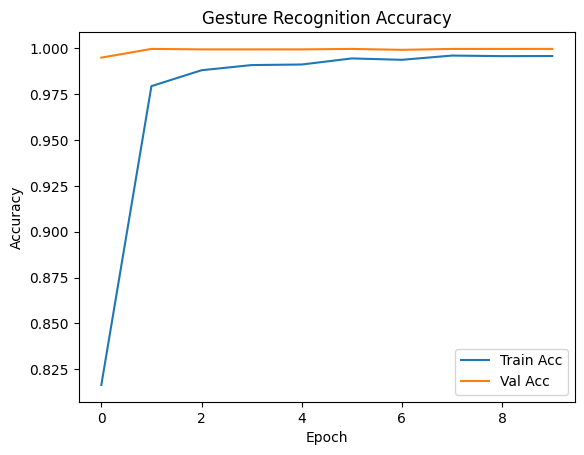

In [20]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Gesture Recognition Accuracy')
plt.legend()
plt.show()
